In [42]:
#!/usr/bin/python3

# Standard Libraries
import argparse
import os
import sys
from tqdm import tqdm

# Python Modules
from collections import Counter
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple
import gc

# Type Hint Libraries
from typing import Optional, Tuple, Union, TypeVar, List
import numpy.typing as npt
import matplotlib.figure
from torch import Tensor

# Math and Data Science Libraries
import numpy as np
import pandas as pd
from scipy.ndimage.filters import convolve

# Plot Libraries
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader


# Image Libraries
import cv2 

import skimage as ski
from skimage import io
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb

# User defined methods and classes
from utils import parse_line
from utils import lines_to_polygons
from utils import build_mask_dataset
from utils import mask_in_set
from utils import nodes_to_points
from utils import plot_image_and_mask
from utils import create_binary_mask

In [2]:
# Path to dataset
DATA_PATH = "C:/Users/rzamb/Documents/UMD/640_Computer_Vision/HW/semanticSegmentation_deepLearning_microstructureCharacterization/aachen_heerlen_dataset/PNG/PNG/"
# Creating a path to save masks
MASKS_PATH = "C:/Users/rzamb/Documents/UMD/640_Computer_Vision/HW/semanticSegmentation_deepLearning_microstructureCharacterization/aachen_heerlen_dataset/masks/"

In [3]:
# Creates a list of the *.png file names in the dataset
image_files = os.listdir(DATA_PATH) 

In [4]:
image_names = []

for file_name in image_files:
    image_names.append(file_name.replace('.png',''))

First step is to generate names for the train set and for the test set.

In [5]:
train_image_names, test_image_names, _, _ = train_test_split(image_names, image_names, test_size=0.2, random_state=42)

In [6]:
train_images = []
test_images = []
train_masks = []
test_masks = []

In [7]:
# Loading train images as grayscale images
for name in train_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    train_images.append(rgb2gray(curr_image))

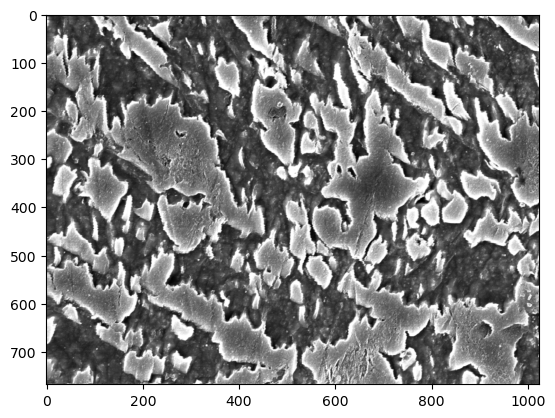

In [8]:
# Testing images were loaded correctly
plt.imshow(train_images[0], cmap=plt.cm.gray)
plt.show()

In [9]:
print('Image shape:         ',train_images[0].shape)
print('Element type:        ',train_images[0].dtype)
print('Data structure type: ',type(train_images[0]))
print('Max. value:          ',np.max(train_images[0]))
print('Min. value:          ',np.min(train_images[0]))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           0.996078431372549
Min. value:           0.0


In [10]:
# Loading train images as grayscale images
for name in train_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    train_masks.append(rgb2gray(curr_mask).round())

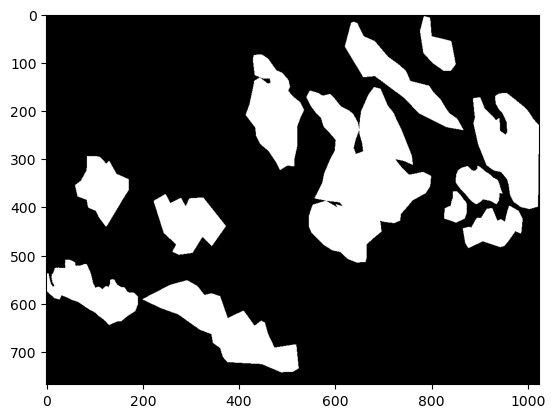

In [12]:
# Testing images were loaded correctly
plt.imshow(train_masks[0], cmap=plt.cm.gray)
plt.show()

In [11]:
print('Image shape:         ',train_masks[0].shape)
print('Element type:        ',train_masks[0].dtype)
print('Data structure type: ',type(train_masks[0]))
print('Max. value:          ',np.max(train_masks[0]))
print('Min. value:          ',np.min(train_masks[0]))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           1.0
Min. value:           0.0


In [13]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    test_images.append(rgb2gray(curr_image))

In [14]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    test_masks.append(rgb2gray(curr_mask).round())

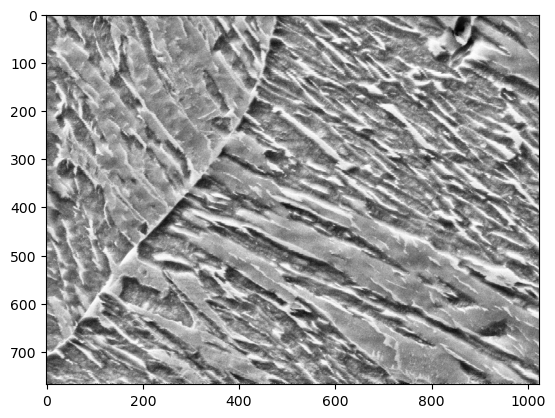

In [19]:
# Showing a test image and its mask
plt.imshow(test_images[15], cmap=plt.cm.gray)
plt.show()

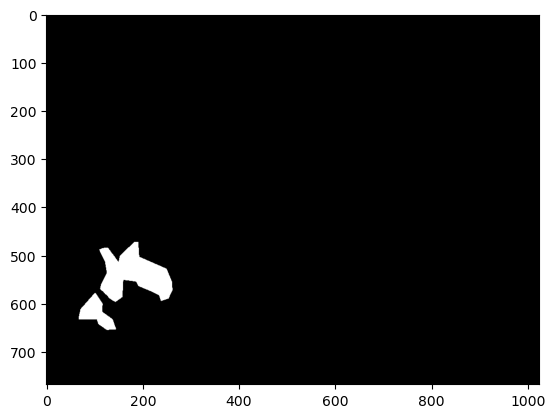

In [20]:
plt.imshow(test_masks[15], cmap=plt.cm.gray)
plt.show()

First I created a custom Dataset class for this particular dataset:

In [33]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, images: list, masks: list):
        super(DataLoaderSegmentation, self).__init__()
        assert len(images) == len(masks), 'Length of image list must be the same of masks list'
        self.img = np.array(images)
        self.msk = np.array(masks)

    def __getitem__(self, index)->Tuple[Tensor]:
            data = self.img[index]
            label = self.msk[index]
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img)

In [35]:
train_dataset = DataLoaderSegmentation(train_images,train_masks)
test_dataset = DataLoaderSegmentation(test_images,test_masks)

In [40]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([768, 1024])
torch.Size([768, 1024])


Next step is creating a dataloader for the network

In [51]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [56]:
# Testing dataloader
train_images_testBatch, train_labels_testBatch = next(iter(train_dataloader))

In [57]:
print(train_labels_testBatch.shape)
print(train_images_testBatch.shape)

torch.Size([16, 768, 1024])
torch.Size([16, 768, 1024])


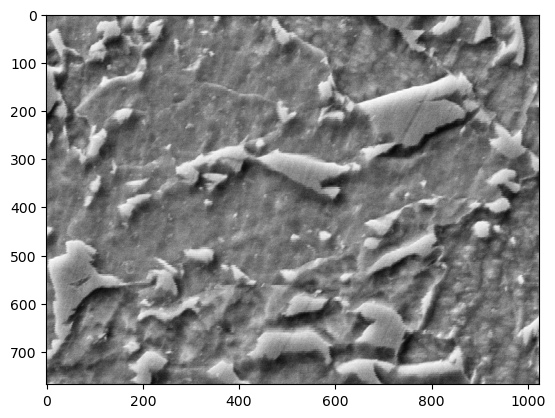

In [58]:
# Showing a test image and its mask
plt.imshow(train_images_testBatch[10], cmap=plt.cm.gray)
plt.show()

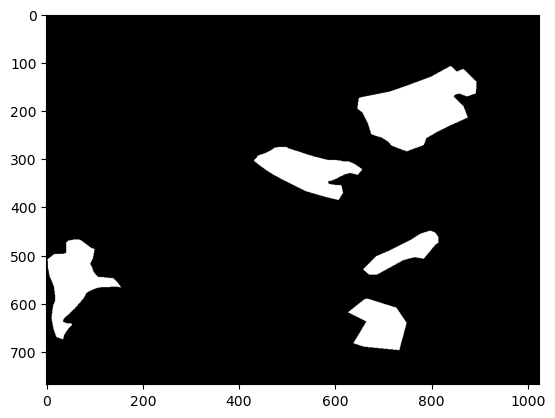

In [59]:
# Showing a test image and its mask
plt.imshow(train_labels_testBatch[10], cmap=plt.cm.gray)
plt.show()

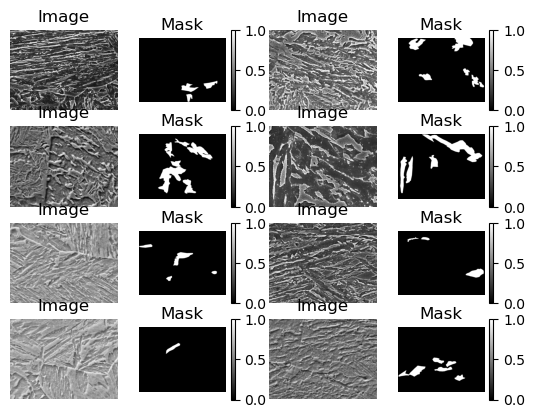

In [66]:
# View images and associated labels
for _ in range(len(train_labels_testBatch)):
    img_number = 0
    for image_slot in range(16):
        ax = plt.subplot(4, 4, image_slot + 1)
        if image_slot % 2 == 0:
            plt.imshow(train_images_testBatch[img_number], cmap=plt.cm.gray) 
            class_name = 'Image'
        else:
            plt.imshow(train_labels_testBatch[img_number], cmap=plt.cm.gray)
            plt.colorbar()
            class_name = 'Mask'
            img_number += 1            
        plt.title(class_name)
        plt.axis("off")